In [1]:
! pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"manimathavan","key":"a0cdb2f4933baaccd034340dbfad4395"}'}

In [3]:
! mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [5]:
! kaggle datasets download -d jangedoo/utkface-new

 99% 329M/331M [00:03<00:00, 84.4MB/s]
100% 331M/331M [00:03<00:00, 92.2MB/s]


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
from PIL import Image
import tensorflow as tf
from tensorflow.keras.initializers import random_uniform, glorot_uniform, constant, identity

2024-02-18 13:05:59.117484: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-18 13:05:59.117601: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-18 13:05:59.228191: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
path = Path("/kaggle/input/utkface-new/UTKFace")
filenames = [file.name for file in path.glob('*.jpg')]

In [ ]:
print(len(filenames))
print(filenames[:3])

23708
['26_0_2_20170104023102422.jpg.chip.jpg', '22_1_1_20170112233644761.jpg.chip.jpg', '21_1_3_20170105003215901.jpg.chip.jpg']


In [ ]:
# Shuffle the filenames
np.random.seed(10)
np.random.shuffle(filenames)

# Extract age and gender labels from filenames
image_paths = [str(file) for file in filenames]  # Convert Path objects to strings
age_labels = [file.split('_')[0] for file in filenames]
gender_labels = [file.split('_')[1] for file in filenames]

In [ ]:
image_paths[:3]

['39_0_1_20170113151528768.jpg.chip.jpg',
 '51_0_0_20170111203742983.jpg.chip.jpg',
 '34_0_1_20170116002253177.jpg.chip.jpg']

In [ ]:
df = pd.DataFrame({
    'image': image_paths,
    'age': age_labels,
    'gender': gender_labels
})

In [ ]:
df.head()

,image,age,gender
0,39_0_1_20170113151528768.jpg.chip.jpg,39,0
1,51_0_0_20170111203742983.jpg.chip.jpg,51,0
2,34_0_1_20170116002253177.jpg.chip.jpg,34,0
3,15_1_2_20170104012024121.jpg.chip.jpg,15,1
4,22_1_0_20170116214345265.jpg.chip.jpg,22,1


In [ ]:
df.dtypes

image     object
age       object
gender    object
dtype: object

In [ ]:
df = df.astype({'age':'float32', 'gender': 'int32'})

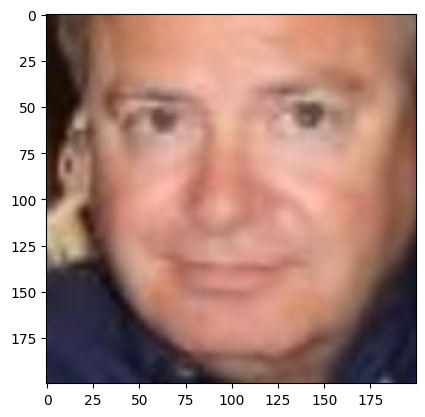

In [ ]:
img = Image.open("/kaggle/input/utkface-new/UTKFace/" + df['image'][1])
plt.imshow(img)
plt.show()

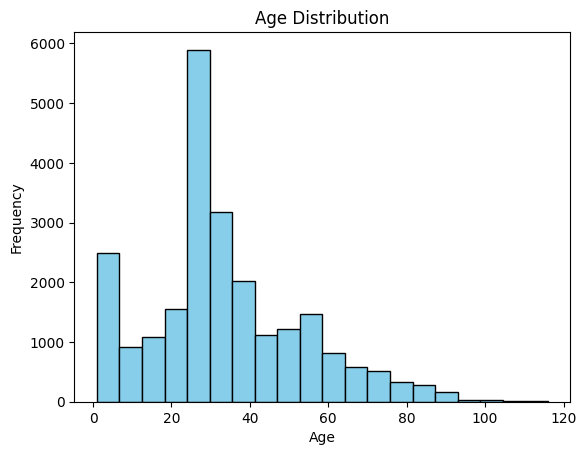

In [ ]:
# Histogram of age
plt.hist(df['age'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Age Distribution')
plt.show()

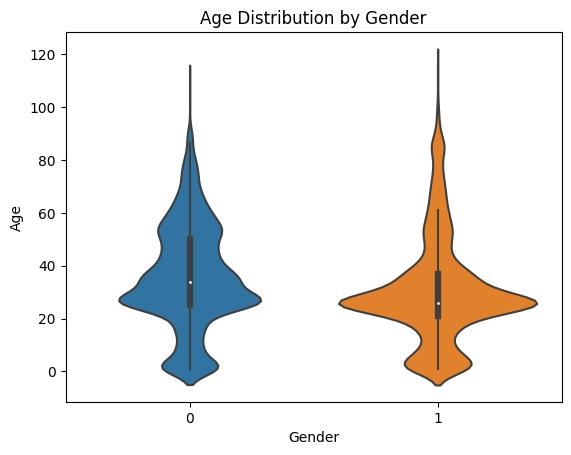

In [ ]:
# Violin plot of age by gender
sns.violinplot(data=df, x='gender', y='age')
plt.xlabel('Gender')
plt.ylabel('Age')
plt.title('Age Distribution by Gender')
plt.show()

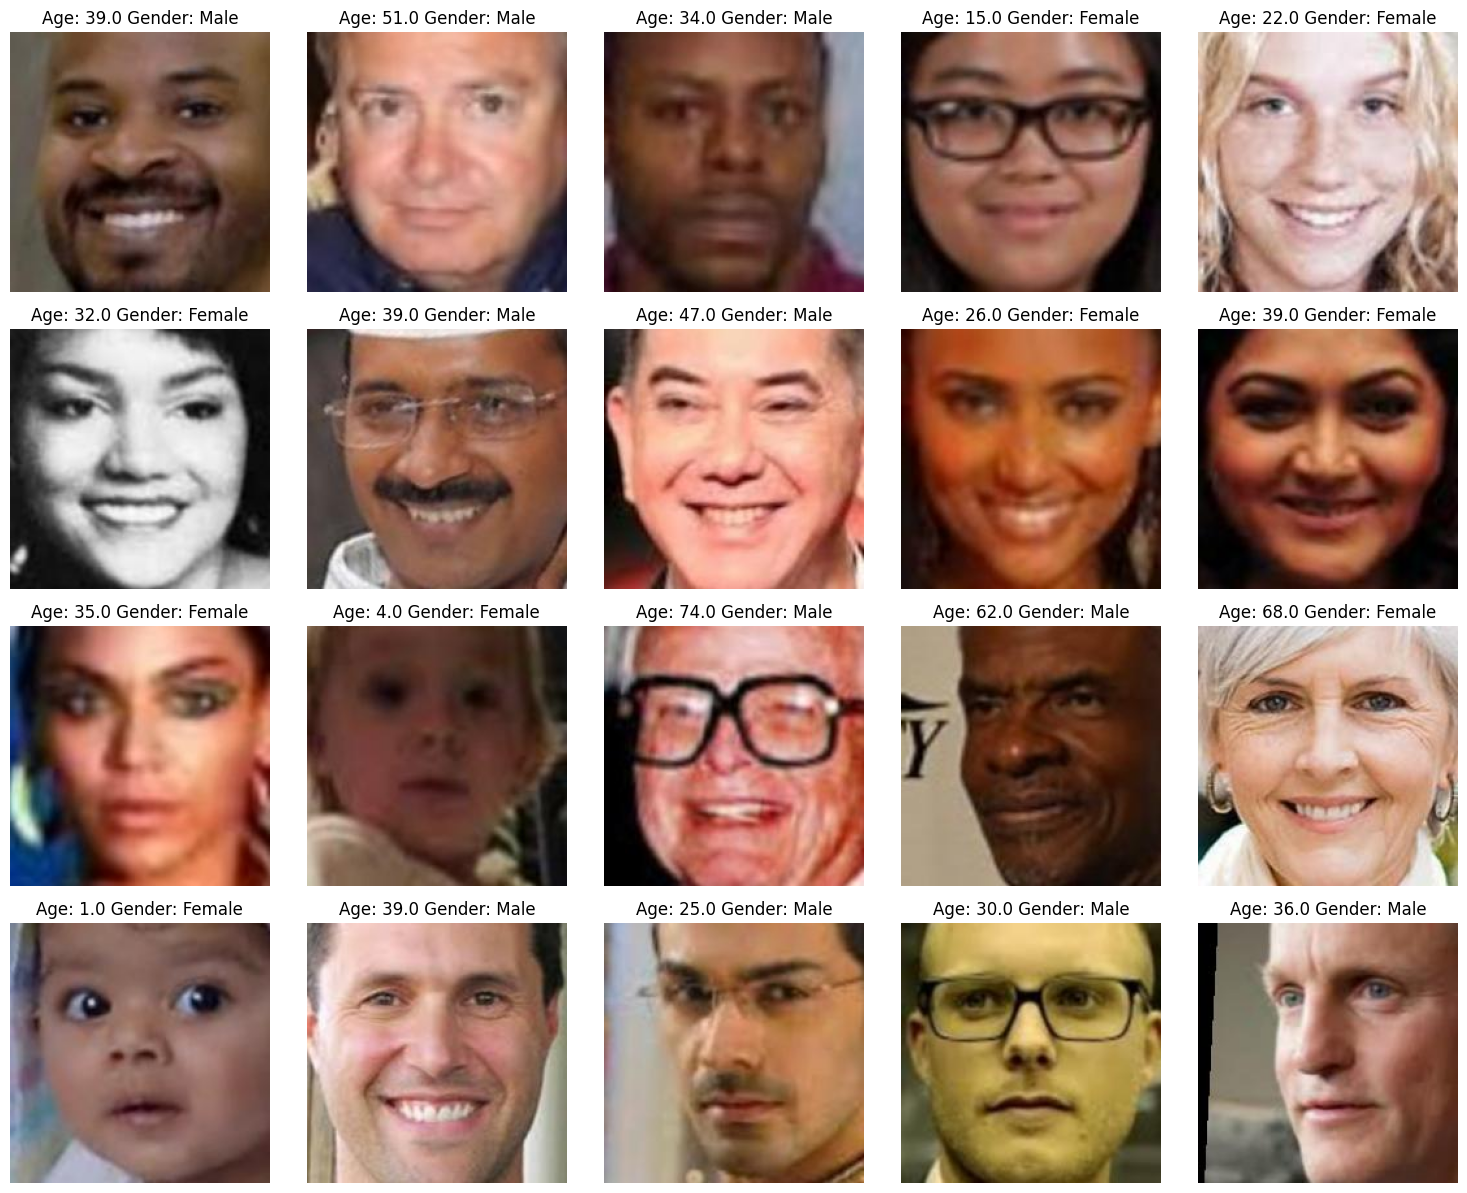

In [ ]:
from keras.preprocessing.image import load_img

gender_dict = {0: 'Male', 1: 'Female'}

files = df.iloc[0:20]
plt.figure(figsize=(15, 15))
for index, (file, age, gender) in files.iterrows():
    plt.subplot(5, 5, index + 1)
    img = load_img("/kaggle/input/utkface-new/UTKFace/" + file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"Age: {age} Gender: {gender_dict[gender]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.85, random_state=42)

train.head()

,image,age,gender
18199,67_0_0_20170109150725032.jpg.chip.jpg,67.0,0
19557,25_1_0_20170116002150531.jpg.chip.jpg,25.0,1
20132,63_0_0_20170111171747607.jpg.chip.jpg,63.0,0
11849,26_0_4_20170117200038821.jpg.chip.jpg,26.0,0
2100,32_0_1_20170113152015975.jpg.chip.jpg,32.0,0


In [ ]:
from keras.preprocessing.image import load_img

x_train = []
for file in train.image:
    img = load_img("/kaggle/input/utkface-new/UTKFace/"+file, grayscale=True)
    img = img.resize((128,128), Image.ANTIALIAS)
    img = np.array(img)
    x_train.append(img)

x_train = np.array(x_train)

x_train = x_train.reshape(len(x_train), 128,128,1)

/tmp/ipykernel_34/3798594471.py:6: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize((128,128), Image.ANTIALIAS)


In [ ]:
x_train.shape

(3556, 128, 128, 1)

In [ ]:
x_train = x_train/255

In [ ]:
y_gender = np.array(train.gender)
y_age = np.array(train.age)

In [ ]:
input_size = (128, 128, 1)

In [ ]:
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from keras.models import Model

inputs = Input((input_size))
X = Conv2D(64, (3, 3), activation='relu', kernel_initializer = glorot_uniform(seed=0))(inputs)
X = BatchNormalization(axis = 3)(X)
X = MaxPooling2D((3, 3))(X)

X = Conv2D(128, (3, 3), activation='relu')(X)
X = MaxPooling2D((2, 2), strides=(2, 2))(X)

X = Conv2D(256, (3, 3), activation='relu')(X)
X = MaxPooling2D((2, 2))(X)

X = Flatten()(X)

dense_1 = Dense(256, activation='relu')(X)
dense_2 = Dense(256, activation='relu' )(X)
dense_3 = Dense(128, activation='relu' )(dense_2)
dropout_1 = Dropout(0.4)(dense_1)
dropout_2 = Dropout(0.4)(dense_3)
output_1 = Dense(1,activation='sigmoid', name='gender_output')(dropout_1)
output_2 = Dense(1, activation='relu', name='age_output')(dropout_2)

model = Model(inputs=[inputs], outputs=[output_1,output_2])

In [ ]:
model.compile(loss=['binary_crossentropy','mae'], optimizer='adam', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 conv2d_3 (Conv2D)           (None, 126, 126, 64)         640       ['input_2[0][0]']             
                                                                                                  
 batch_normalization_1 (Bat  (None, 126, 126, 64)         256       ['conv2d_3[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 max_pooling2d_3 (MaxPoolin  (None, 42, 42, 64)           0         ['batch_normalization_1[0]

In [ ]:
model_history = model.fit(x=x_train, y=[y_gender, y_age], batch_size = 10, epochs=20, validation_split= 0.1)

Epoch 1/20


I0000 00:00:1708261821.405118      85 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


320/320 [==============================] - 10s 10ms/step - loss: 15.5335 - gender_output_loss: 0.7142 - age_output_loss: 14.8193 - gender_output_accuracy: 0.6894 - age_output_accuracy: 0.0463 - val_loss: 28.8194 - val_gender_output_loss: 0.5943 - val_age_output_loss: 28.2252 - val_gender_output_accuracy: 0.7837 - val_age_output_accuracy: 0.0421
Epoch 2/20
320/320 [==============================] - 3s 8ms/step - loss: 12.2262 - gender_output_loss: 0.4814 - age_output_loss: 11.7448 - gender_output_accuracy: 0.7694 - age_output_accuracy: 0.0241 - val_loss: 12.2915 - val_gender_output_loss: 0.6044 - val_age_output_loss: 11.6872 - val_gender_output_accuracy: 0.6152 - val_age_output_accuracy: 0.0730
Epoch 3/20
320/320 [==============================] - 3s 8ms/step - loss: 10.8487 - gender_output_loss: 0.4244 - age_output_loss: 10.4242 - gender_output_accuracy: 0.7959 - age_output_accuracy: 0.0134 - val_loss: 12.0137 - val_gender_output_loss: 0.4289 - val_age_output_loss: 11.5848 - val_gender

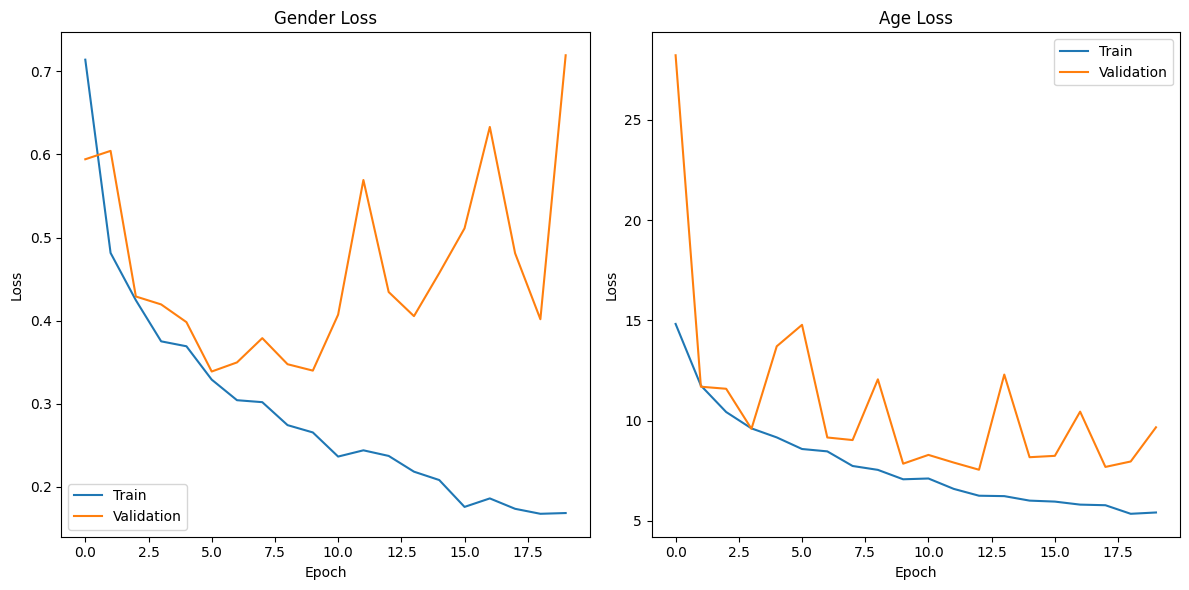

In [ ]:
# Plotting gender and age losses together
plt.figure(figsize=(12, 6))

# Gender loss
plt.subplot(1, 2, 1)
plt.plot(model_history.history['gender_output_loss'], label='Train')
plt.plot(model_history.history['val_gender_output_loss'], label='Validation')
plt.title('Gender Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Age loss
plt.subplot(1, 2, 2)
plt.plot(model_history.history['age_output_loss'], label='Train')
plt.plot(model_history.history['val_age_output_loss'], label='Validation')
plt.title('Age Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

Original: Gender =  Female  Age =  28.0
1/1 [==============================] - 0s 17ms/step
Prediction: Gender =  Female  Age =  31


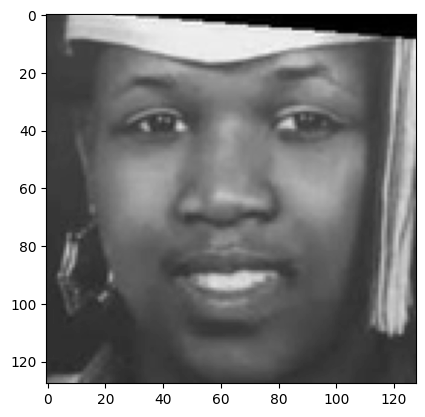

Original: Gender =  Male  Age =  26.0
1/1 [==============================] - 0s 18ms/step
Prediction: Gender =  Male  Age =  30


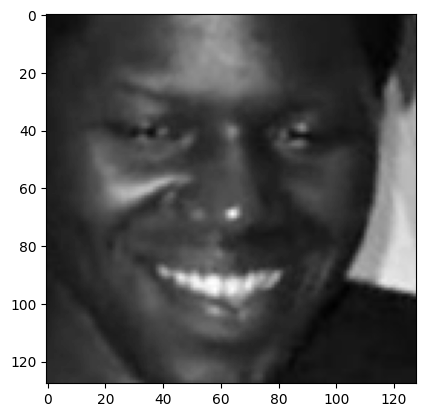

Original: Gender =  Female  Age =  21.0
1/1 [==============================] - 0s 18ms/step
Prediction: Gender =  Female  Age =  23


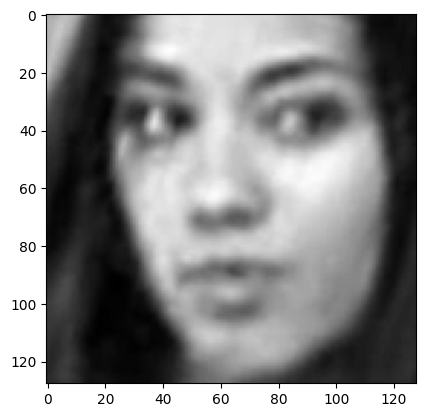

In [ ]:
# Define a function for predicting and visualizing multiple test images
def predict_and_visualize(index_list, x_test, y_gender_true, y_age_true, model, gender_dict):
    for index in index_list:
        print("Original: Gender = ", gender_dict[y_gender_true[index]], " Age = ", y_age_true[index])

        # Predict gender and age
        pred = model.predict(x_test[index].reshape(1, 128, 128, 1))
        pred_gender = gender_dict[round(pred[0][0][0])]
        pred_age = round(pred[1][0][0])

        print("Prediction: Gender = ", pred_gender, " Age = ", pred_age)

        # Display the image
        plt.imshow(x_test[index].reshape(128, 128), cmap='gray')
        plt.show()

# Example usage:
index_list = [40,43,30]  # List of indices of test images to predict and visualize
predict_and_visualize(index_list, x_train, y_gender, y_age, model, gender_dict)